\# Deep Learning with PyTorch : Building a Generative Adversarial Network

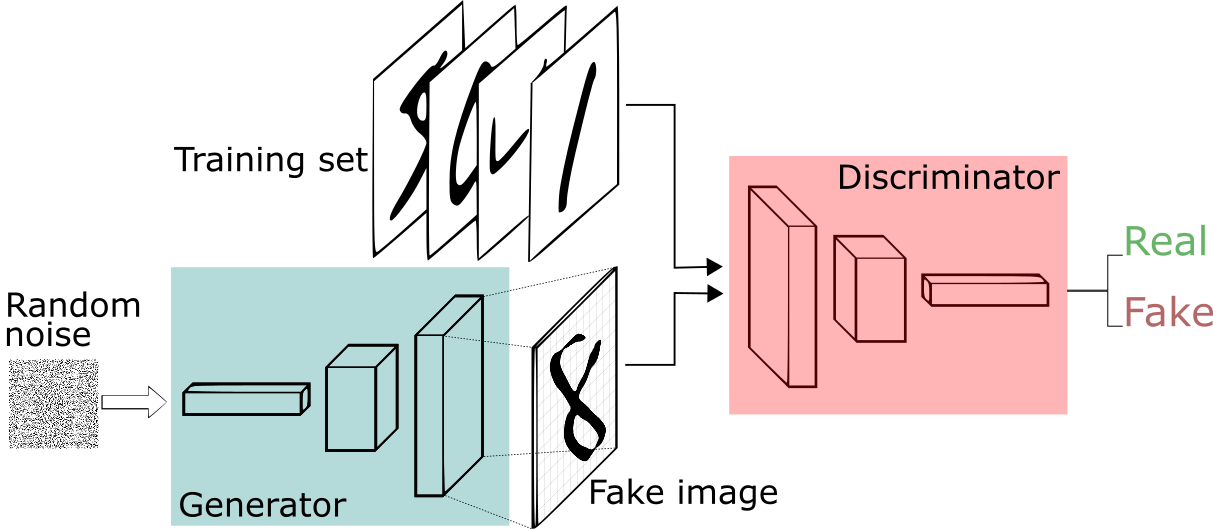

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

Configuring the project parameters

In [ ]:
# We want to run the model on GPU so we use "CUDA", hence device will be CUDA

device = 'cuda'

batch_size = 25 # We want the train loader to load the data in batch sizes
noise_dim = 64 # Dimension of noise vector to be passed to the generator

# Optimizer Parameters
lr = 0.0002 # The rate at which the model will learn the data
beta1 = 0.5
beta2 = 0.999

# Training Parameters
epochs = 10 # Number of times to run the training loop




# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

# Image Transformation

The data goes through a sequence of transformations that will be applied to the training images of the MNIST dataset. These transformations are commonly used in deep learning to make the model more robust and prevent overfitting. Here's a step-by-step explanation:

In [ ]:
# Performing Transformations on the images.
# Creating a function T.compose(...) to chain multiple image transformations together, and applying them sequentially

train_augs = T.Compose([
    T.RandomRotation((-0.7, 0.7)), # randomly rotates the image by an angle between -0.7 and 0.7 radians. This helps the model learn to recognize digits even if they are slightly rotated
    T.Resize((28, 28)), # This transformation resizes the image to 28x28 pixels. This ensures all images have a consistent size, which is required by the model. (MNIST images are originally 28x28)
    T.ToTensor(), # This transformation converts the image  format from a PIL/numpy Image (a common image format in Python) to a PyTorch tensor image format
    T.Normalize((0.5,), (0.5,)) # This transformation normalizes the pixel values of the image. It subtracts the mean (0.5) from each pixel and divides by the standard deviation (0.5). Normalization helps improve the training process by scaling the input data to a specific range.


])

# In summary:

train_augs is a set of instructions for how to pre-process images before they are fed into the deep learning model for training. This makes the model more robust by introducing variations in the training data.

In [ ]:
#Downloading the MNIST data
image_data = datasets.MNIST(root = './data', download = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.13MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Label : 5


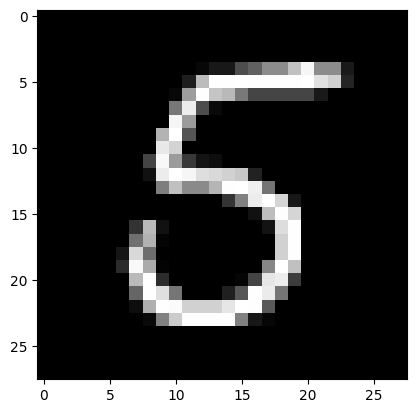

In [ ]:
# Viewing Sample of the loaded image_data eg. on index 24
image, label = image_data[768]
print(f'Label : {label}')
plt.imshow(image.squeeze(), cmap = 'gray')
plt.show()

In [ ]:
# Checking how many images are present in the datasets
print('The total images present in the image_data dataset are:', len(image_data))

The total images present in the image_data dataset are: 60000


# Load Dataset Into Batches

In [ ]:
# Loading the libraries

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
# Dividing the image_data dataset into batches of sizes for easy iteration using trainloader container
trainloader = DataLoader(image_data, batch_size = batch_size, shuffle = True)

print('The total batches present in the trainloader are:', len(trainloader))

The total batches present in the trainloader are: 2400


#####Summary
The line trainloader = DataLoader(image_data, batch_size = batch_size, shuffle = True) creates a trainloader object that:

- Takes the MNIST dataset (image_data).
- Divides it into mini-batches of size 128.
- Randomly shuffles the images before creating the mini-batches.
- Then prints out the total number of batches present in the trainloader.

This trainloader can then be used in your training loop to efficiently feed data to your model. You can iterate through trainloader to access these mini-batches of images and labels. This is a standard practice in PyTorch for training deep learning models.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([25, 1, 28, 28])
torch.Size([25])


#####summary

This code snippet grabs one batch of images and labels from your training data loader (trainloader) and then displays the dimensions of those batches. This is often done to verify that the data is being loaded correctly before feeding it into a deep learning model.

In [ ]:
# Visualizing the data in the model to see how its performing
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()



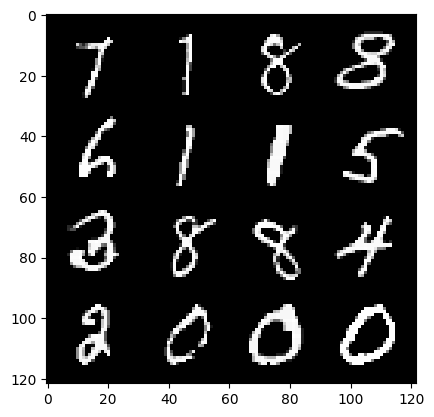

In [ ]:
show_tensor_images(images, num_images= 16, size=(1, 28, 28))


# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
# Loading neccessary Libraries
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator (The Discriminator's job in a Generative Adversarial Network (GAN)
is to distinguish between real images (from the MNIST dataset in this case) and fake images (generated by another network called the Generator))

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

"\n\nNetwork : Discriminator (The Discriminator's job in a Generative Adversarial Network (GAN) \nis to distinguish between real images (from the MNIST dataset in this case) and fake images (generated by another network called the Generator))\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                  

**"Discriminator"**.

The Discriminator's job in a Generative Adversarial Network (GAN) is to distinguish between real images (from the MNIST dataset in this case) and fake images (generated by another network called the Generator).

**Input:**

- (bs, 1, 28, 28): This represents the input to the Discriminator.

- - bs: Stands for "batch size", indicating the number of images processed at once.
-- 1: Represents the number of color channels in the image (MNIST images are grayscale, so there's only 1 channel).
-- 28, 28: These are the height and width of the input images (MNIST images are 28x28 pixels).

**Layers:**

The Discriminator is composed of a series of layers that process the input:

1. Conv2d (Convolutional Layer):

- - in_channels = 1: Takes the grayscale image (1 channel) as input.
- - out_channels = 16: Produces 16 output channels (feature maps).
- - kernel_size = (3,3): Uses a 3x3 filter to scan the image.
- - stride = 2: Moves the filter by 2 pixels at a time. This reduces the spatial dimensions of the output.
- - Output: (bs, 16, 13, 13) - A batch of feature maps with 16 channels, and reduced height/width (13x13).

2. BatchNorm2d (Batch Normalization):

- - Normalizes the output of the previous layer across the batch. This helps stabilize and speed up training.
- - Output: (bs, 16, 13, 13) - Dimensions remain the same.

3. LeakyReLU (Leaky Rectified Linear Unit):

- - Applies an activation function to introduce non-linearity. LeakyReLU allows a small, non-zero gradient for negative inputs, preventing the network from getting stuck.
- - Output: (bs, 16, 13, 13) - Dimensions remain the same.

4. Conv2d, BatchNorm2d, LeakyReLU:

- This sequence is repeated with different parameters:
- - in_channels = 16 (taking output from the previous layer)
- - out_channels = 32 (increasing the number of feature maps)
- - kernel_size = (5,5)
- - stride = 2
- Output: (bs, 32, 5, 5) - Feature maps are - further reduced in size (5x5).

5. Conv2d, BatchNorm2d, LeakyReLU:

- Repeated again with:
- - in_channels = 32
- - out_channels = 64
- - kernel_size = (5,5)
- - stride = 2
- Output: (bs, 64, 1, 1) - Feature maps are now 1x1.

6. Flatten:

- Converts the multi-dimensional feature maps into a single vector.
- Output: (bs, 64) - A batch of 64-dimensional vectors.

7. Linear (Fully Connected Layer):

- in_features = 64 (takes the flattened vector as input)
- out_features = 1 (produces a single output value).
- Output: (bs, 1) - A batch of single values. This output represents the Discriminator's prediction of whether each input image is real or fake (typically a value close to 1 for real, and close to 0 for fake).

**In Summary:**

The Discriminator takes an image as input, passes it through a series of convolutional layers to extract features, flattens the features, and then uses a linear layer to make a final prediction about the image's authenticity. Each layer plays a role in learning increasingly complex patterns in the data to help the Discriminator make accurate judgments. I hope this explanation is helpful! Let me know if you have any other questions.

In [ ]:
import torch.nn as nn # Import the necessary module

# Creating A function to define how the Discriminator will take input, the output it will produce, the size of convolution and number of pixels(strides) the filter will move in each step
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

This function takes an image, extracts features from it using a filter, normalizes the results, and then applies a function to make the output more expressive. This small unit can then be used multiple times within the discriminator network to build a more complex and powerful image analyzer.

In [ ]:
# Creating the Discriminator Network

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = get_disc_block(1, 16, (3,3), 2) # Each get_disc_block call creates a sequence of a convolutional layer,
        self.block2 = get_disc_block(16, 32, (5,5), 2) # a batch normalization layer, and a LeakyReLU activation function.
        self.block3 = get_disc_block(32, 64, (5,5), 2) #These blocks are essential for extracting features from the input images.

        self.flatten = nn.Flatten()  #his line creates a flattening layer, which converts the multi-dimensional output of the convolutional blocks into a single vector.
        self.linear = nn.Linear(64, 1) # This creates a linear (fully connected) layer that takes the flattened vector as input and produces a single output value.
                                        # This output represents the Discriminator's prediction (real or fake)


    def forward(self, images):  # specifies how data is processed to produce a prediction about the authenticity of an input image.
      x1 = self.block1(images)
      x2 = self.block2(x1)
      x3 = self.block3(x2)
      x4 = self.flatten(x3)
      x5 = self.linear(x4)

      return x5

      x = self.flatten(x)
      x = self.linear(x)

      self.flatten = nn.Flatten()
      self.linear = nn.Linear(64, 1)

      return x

In [ ]:
import torch

# Check if CUDA is available. If not, use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

D = Discriminator().to(device)

from torchsummary import summary
summary(D, (1, 28, 28))

CUDA is not available. Using CPU instead.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
-------------------------------------------------------

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

Since the Convolutional layer has an input image size and dimension as (bs, channel, height, width).

We have to Reshape the image input from (bs, noise_dim) TO

(bs, noise_dim, 1, 1).

Where:

    bs = bs
    noise_dim = channel
    1 = height
    1 - width


In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
# Creating the Network

class Generator(nn.Module):
  def __init__(self, z_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block2 = get_gen_block(256, 128, (4,4), 1)
    self.block3 = get_gen_block(128, 64, (3,3), 2)
    self.block4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, noise):
    #(bs,  noise_dim) --> (bs, noise_dim, 1, 1)
    x = noise.view(len(noise), self.noise_dim, 1, 1)
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)

    return x4

In [ ]:
G = Generator(noise_dim).to(device)

from torchsummary import summary
summary(G, (64, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             ReLU-12            [-1, 1, 28, 28]               0
Total params: 747,843
Trainable params: 747,843
Non-trainable params: 0
-------------------------------

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = Discriminator()
G = Generator(noise_dim)
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(descrm_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(descrm_pred)
  loss = criterion(descrm_pred, ground_truth)
  return loss

def fake_loss(descrm_pred):
  criterion = nn.BCEWithLogitsLoss()
  labels = torch.ones_like(descrm_pred)
  loss = criterion(descrm_pred, labels)

def fake_loss(descrm_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(descrm_pred)
  loss = criterion(descrm_pred, ground_truth)
  return loss

In [ ]:
# Creating Optimizer for Descriminator and Generator

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta1, beta2))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta1, beta2))

# Training Loop

In [ ]:
for i in range(epochs):

  total_d_loss = 0
  total_g_loss = 0

  for real_images, _ in tqdm(trainloader):

    real_images = real_images.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_images = G(noise)

    # Find loss and update weights for D

    d_optimizer.zero_grad()

    fake_images = G(noise).detach()
    descrm_pred_fake = D(fake_images)
    D_fake_loss = fake_loss(descrm_pred_fake)

    descrm_pred_real = D(real_images)
    D_real_loss = real_loss(descrm_pred_real)

    d_loss = D_fake_loss + D_real_loss

    d_loss.backward()
    d_optimizer.step()

    total_d_loss += d_loss.item()

    # Find loss and update weights for G

    g_optimizer.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_images = G(noise)

    descrm_pred_fake = D(fake_images)
    g_loss = real_loss(descrm_pred_fake)


    total_g_loss += g_loss.item()

    g_loss.backward()
    g_optimizer.step()

    average_d_loss = total_d_loss / len(trainloader)
    average_g_loss = total_g_loss / len(trainloader)

    print('Epoch : {} | D_loss : {} | G_loss : {}'.format(i+1, average_d_loss, average_g_loss))

    show_tensor_images(fake_images)





In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

## 👤 Author

**Emeka Philian Ogbonna**  
📧 ogbonnaemeka665@gmail.com  
🔗 [LinkedIn Profile](https://www.linkedin.com/in/emekaogbonna/)